<a href="https://colab.research.google.com/github/neuroidss/EEG-GAN-audio-video/blob/main/bdf_coh_3d_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
ch_names_sg2 = ['FP1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8','FC6','FC2','F4','F8','AF4','FP2','Fz','Cz']
ch_locations_sg2=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
bands = [[8.,12.]]
methods = ['coh']
duration=5*1/8
overlap=0
fps_sg2=1
#if generate_wavegan:
fps_wg=1#hz/(32768*2)
fps_sg2=fps_wg*4
#fps_sg2=fps_wg
fps_hm=fps_wg

if 2*1/fps_wg>duration:
  duration=2*1/fps_wg
  overlap=0

#if generate&gen_wavegan:
#  dim_wg = 100
#if generate&gen_stylegan2:
#  dim_sg2 = 512
#if generate&gen_sg2_shawwn:
#  dim_sg2 = 1024

#stepSize = 1/pow(2,24)
#vref = 2.50 #2.5V voltage ref +/- 250nV
#gain = 8

#vscale = (vref/gain)*stepSize #volts per step.
#uVperStep = 1000000 * ((vref/gain)*stepSize) #uV per step.
#scalar = 1/(1000000 / ((vref/gain)*stepSize)) #steps per uV.

In [3]:
def download_file_from_google_drive(file_id,dest_path):
  import os.path
  if not os.path.isfile(dest_path):  
    !mkdir -p $(dirname {dest_path})
    !wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='{file_id} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    !wget --load-cookies cookies.txt -O {dest_path} 'https://docs.google.com/uc?export=download&id='{file_id}'&confirm='$(<confirm.txt)

In [4]:
!mkdir /content/eeg

mkdir: cannot create directory ‘/content/eeg’: File exists


In [5]:
!pip install --upgrade gdown
#!pip install googledrivedownloader
#from google_drive_downloader import GoogleDriveDownloader as gdd
files_path=[]
#if generate&gen_drums:
files_path = [['1Nfzi6yT83SBZxtgIYVtYp7C7g_Sq9OdS', '/content/eeg/record-[2019.11.13-22.23.59].csv'],
              ['1LtMfr9GduR3semMVgh_6JoUSKbCG8XbH', '/content/eeg/record-[2020.06.28-14.26.09].csv']]
for i in range(len(files_path)):
#  gdd.download_file_from_google_drive(file_id=files_path[i][0], dest_path=files_path[i][1])
  download_file_from_google_drive(file_id=files_path[i][0], dest_path=files_path[i][1])


You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
  !pip install Pillow
  import PIL.Image 
  !pip install tqdm
  from tqdm import tqdm
  !pip install imageio==2.4.1
  !pip install imageio-ffmpeg==0.4.3 pyspng==0.1.0


You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
!mkdir '/content/out'


mkdir: cannot create directory ‘/content/out’: File exists


In [8]:
!pip install mne==0.23.3
!pip install pandas
!pip install matplotlib

import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, compute_source_psd

from mne.connectivity import spectral_connectivity, seed_target_indices

import pandas as pd
import numpy as np


You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.


In [9]:
    key = 0
    idx = 0

    data_path = '/content/eeg'
    #raw_fname = data_path + '/record-[2019.11.13-22.23.59].gdf'
    #raw = mne.io.read_raw_gdf(raw_fname, preload=True)

    path = data_path

    ch_names = ['FP1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8','FC6','FC2','F4','F8','AF4','FP2','Fz','Cz']
    data = pd.read_csv(path + '/record-[2019.11.13-22.23.59].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #ch_names = ['FP1','F3','P3','O1','O2','P4','F4','FP2']
    #data = pd.read_csv(path + '/record-[2020.06.28-14.26.09].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #data = pd.read_csv(path + '/record-[2020.06.28-00.36.11].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    #data = pd.read_csv(path + '/record-[2020.06.29-19.49.23].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #print(data)
    data_transpose=np.transpose(data)

    sfreq = 512 
    ch_types=['eeg']*len(ch_names)
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq, ch_types=ch_types)
    #info = mne.create_info(sfreq = sfreq)
    raw = mne.io.RawArray(data_transpose, info)
    #raw.plot()

    # Setup for reading the raw data
    #raw = io.read_raw_fif(raw_fname, verbose=False)
    #events = mne.find_events(raw, stim_channel='STI 014')
    #inverse_operator = read_inverse_operator(fname_inv)
    #raw.info['bads'] = ['MEG 2443', 'EEG 053']

    # picks MEG gradiometers
    #picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)
    picks = ch_names

Creating RawArray with float64 data, n_channels=32, n_times=157376
    Range : 0 ... 157375 =      0.000 ...   307.373 secs
Ready.


In [10]:
#!pip install imageio==2.9
!pip install imageio==2.4.1
!pip install imageio-ffmpeg==0.4.3 pyspng==0.1.0

You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
#import imageio
#fps=10
#out = imageio.get_writer('/content/out/output.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')

#for img in imgs:
#  out.append_data(np.asarray(img))
#out.close()
 

In [12]:
bands = [[8.,12.]]
#bands = [[4.,7.],[8.,12.],[13.,29.]]
#bands = [[8.,12.],[8.,12.],[8.,12.]]
#bands_name = ['theta','alpha','beta']
datas=[]
for band in range(len(bands)):
 datas.append(raw)
# datas.append(raw.filter(l_freq=bands[band][0], h_freq=bands[band][1],method='iir'))
#theta_data = raw.filter(l_freq=4, h_freq=7,method='iir')
#alpha_data = raw.filter(l_freq=8, h_freq=12,method='iir')
#beta_data = raw.filter(l_freq=13, h_freq=29,method='iir')

In [13]:
methods = ['coh']
#methods = ['ciplv']
#methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'wpli']
epochs = []
for band in range(len(bands)):
# epochs.append(mne.make_fixed_length_epochs(datas[band], 
#                                            duration=0.1, preload=False))
 epochs.append(mne.make_fixed_length_epochs(datas[band], 
                                            duration=5*1/8, preload=False, overlap=5*1/8-0.1))
# epochs.append(mne.make_fixed_length_epochs(datas[band], duration=1.25, preload=False, overlap=1.15))
#epochs = [mne.make_fixed_length_epochs(theta_data, duration=0.1, preload=False),
#          mne.make_fixed_length_epochs(alpha_data, duration=0.1, preload=False),
#          mne.make_fixed_length_epochs(beta_data, duration=0.1, preload=False)]
#epochs = mne.make_fixed_length_epochs(alpha_data, duration=0.1, preload=False)
#epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=True)
#epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True)
#epochs = mne.make_fixed_length_epochs(raw, duration=1, preload=False)
#event_related_plot = epochs.plot_image(picks=['FP1'])

Not setting metadata
Not setting metadata
3068 matching events found
No baseline correction applied
0 projection items activated


In [14]:
#fmin=8.
#fmax=13.
fmin=bands[0][0]
fmax=bands[0][1]+1.
          
sfreq = raw.info['sfreq']  # the sampling frequency
#con_methods = ['coh', 'pli', 'ciplv']
con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'wpli']
#con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli', 'wpli2_debiased']
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
#    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=10)
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs[1][2000:2010], method=con_methods, mode='multitaper', sfreq=sfreq, 
#    faverage=True, mt_adaptive=True, n_jobs=1)
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs[0][2000,2001], method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
#    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    epochs[0][2000:2010], method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..0.623s for estimation (320 points)
    frequencies: 8.0Hz..12.8Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, ciPLV, PPC, PLI, WPLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]


In [15]:
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c[:, :, 0]

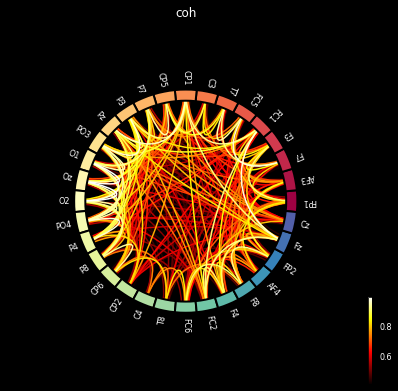

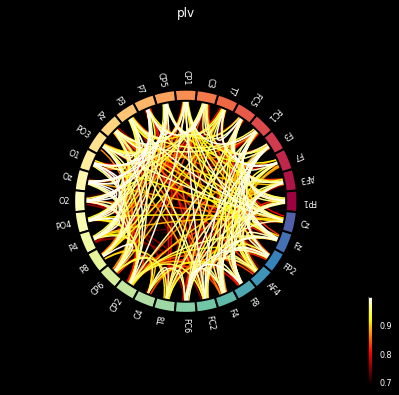

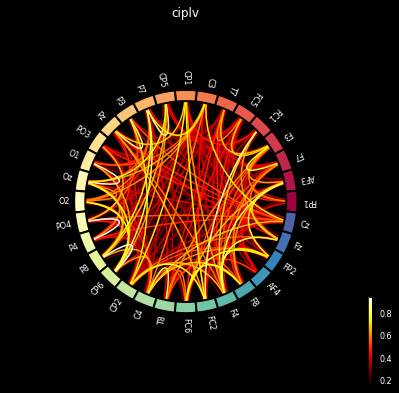

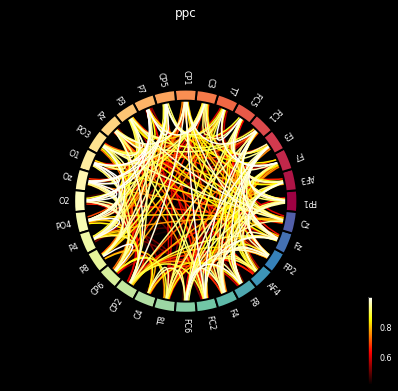

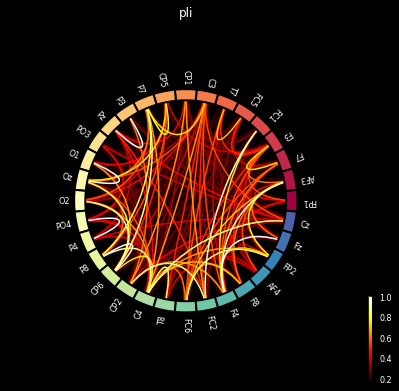

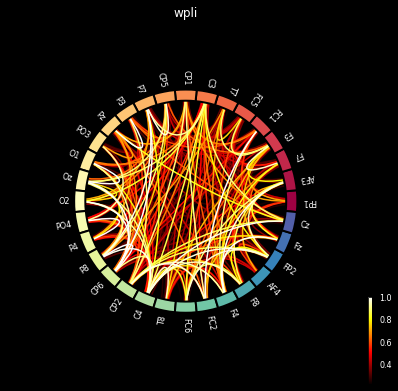

In [16]:
from mne.viz import circular_layout, plot_connectivity_circle
import matplotlib.pyplot as plt

label_names = ch_names

#plot_connectivity_circle(con_res['pli'], label_names, 
#                                                  title='All-to-All Connectivity (PLI)')
#fig = plt.figure(num=None, figsize=(8, 4), facecolor='black')
no_names = [''] * len(label_names)
for ii, method in enumerate(con_methods):
    plot_connectivity_circle(con_res[method], label_names, n_lines=300,
                             title=method)
    #plot_connectivity_circle(con_res[method], label_names, n_lines=300,
    #                         title=method, padding=0, fontsize_colorbar=6,
    #                         fig=fig, subplot=(1, 8, ii + 1))

    #plot_connectivity_circle(con_res[method], no_names, n_lines=300,
    #                         title=method, padding=0, fontsize_colorbar=6,
    #                         fig=fig, subplot=(1, 6, ii + 1))
plt.show()

In [17]:
con_res['coh']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.64715654, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.80520113, 0.60712289, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.71661278, 0.85279984, 0.52570615, ..., 0.        , 0.        ,
        0.        ],
       [0.72335269, 0.77977542, 0.4425438 , ..., 0.77876264, 0.        ,
        0.        ],
       [0.20529402, 0.27715092, 0.24975996, ..., 0.35771778, 0.6327656 ,
        0.        ]])

In [18]:
import io
from PIL import Image
import matplotlib.pyplot as plt

In [28]:
import imageio
fps=10
out = imageio.get_writer('/content/out/output.mp4', fps=fps)
#out = imageio.get_writer('/content/out/output.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')

!pip install mne-connectivity

from mne_connectivity.viz import plot_sensors_connectivity

# Generate random breaks and display audio

# CHANGE THIS to change number of examples generated
#n_generate = 30
#n_generate = 150
#n_generate = 300
#n_generate = 305
#n_generate = 390

# Sample latent vectors
#seed = 666 # change this seed to generate different set of breaks
#np.random.seed(seed)
#_z = (np.random.rand(n_generate, dim) * 2.) - 1.


hz=44100
#hz=39936
#hz=int(32768*2*(600/240))
#hz=int(32768*2*(480/240))
#hz=int(32768*2*(360/240))
#hz=int(32768*2*(300/240))
#hz=int(32768*2*(265/240))
#hz=int(32768*2*(250/240))
#hz=int(32768*2*(240/240)*1.6666666)
#hz=int(32768*2*(240/240))
#hz=int(32768*2*(120/240))
#fps=hz/(32768*2)
#fps=10
#fps=0.5
#fps=44100/(32768*2)
#fps=1
#fps=1/3
#fps=1.5

#n_generate=int((307-2)*fps)
#n_generate=int((160-2)*fps)
#n_generate=int((1598-2)*fps)
n_generate=int((1648-2)*fps)
#n_generate=int((10-2)*fps)
#n_generate=int((1607-2)*fps)
#n_generate=150
part_len = 10
#part_len = 275
dim = 512


n_parts = n_generate//part_len
if n_generate%part_len>0:
    n_parts=n_parts+1

vol=0.1

psd_array=np.random.rand(part_len, dim) 

#out = imageio.get_writer('./output.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')

#Gs_kwargs = dnnlib.EasyDict()
#Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
#Gs_kwargs.randomize_noise = False

imgs = []
imgs1 = []


#z_avg_samples=n_generate
#for i in range(n_generate): # display separate audio for each break
for j in range(n_parts): # display separate audio for each break
    for i in range(part_len): # display separate audio for each break
        ji = j * part_len + i
        
        if (i==0) and (n_generate-ji<part_len):
            psd_array=np.random.rand((n_generate-ji), dim) 


        eeg_step=ji
        #print (f'EEG step: {(eeg_step/3):.1f} s')
        tmin, tmax = 0+(eeg_step/fps), 2+(eeg_step/fps)  # use the first 120s of data
        #tmin, tmax = 0+(10*eeg_step/512), 2+(10*eeg_step/512)  # use the first 120s of data
        fmin, fmax = 0.5, 256  # look at frequencies between 4 and 100Hz
        #fmin, fmax = 0.5, 50  # look at frequencies between 4 and 100Hz
        #fmin, fmax = 8, 12  # look at frequencies between 4 and 100Hz
        #n_fft = 512  # the FFT size (n_fft). Ideally a power of 2
        n_fft = 1024  # the FFT size (n_fft). Ideally a power of 2
        #n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2
        #label = mne.read_label(fname_label)
        
        print(str(ji) + '/' + str(n_generate))
        #logger = logging.getLogger()
        #logger.disabled = True

        sfreq = raw.info['sfreq']  # the sampling frequency
        
        psds=np.zeros(dim)
        
        for method in range(len(methods)):
         for band in range(len(bands)):
          #fmin=8.
          #fmax=13.
          fmin=bands[band][0]
          fmax=bands[band][1]
          if band == 0:
           con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
            epochs[band][ji:ji+10], method=methods[method], mode='multitaper', sfreq=sfreq, fmin=fmin,
            fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
          #con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
          #  epochs[band][ji,ji+1], method=methods[method], mode='multitaper', sfreq=sfreq, fmin=fmin,
          #  fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
          psds_shift1=int(round(method*len(bands)+band)*(len(ch_names)*(len(ch_names)-1)/2))
          ji1=0
          for j1 in range(0,len(ch_names)): # display separate audio for each break
            for i1 in range(0,j1): # display separate audio for each break
              psds[ji1+psds_shift1]=(con[j1][i1][0]-0.5)*1
              ji1 = ji1+1
        #psds, freqs = mne.time_frequency.psd_welch(raw, picks=picks,
        #                 tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax,
        #                 n_fft=n_fft)
        #logger.disabled = False

        #print(freqs)
        #print(psds)
        
        psd_array[i]=psds
        ##z_samples = psds

        #w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
        #w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
        ##z_avg = np.mean(z_samples, axis=0)      # [1, 1, C]
        #z_avg = np.mean(z_samples, axis=0, keepdims=True)      # [1, 1, C]
        ##psd_array[i]=z_avg
        #psd_array[i]=z_avg
        #print(z_avg)
        #z_std = (np.sum((z_samples - z_avg) ** 2) / z_avg_samples) ** 0.5

        #psd_array[i]=psds
        #psds_transpose=np.transpose(psds)
        #plt.plot(freqs,psds_transpose)
        #plt.xlabel('Frequency (Hz)')
        #plt.ylabel('PSD (dB)')
        #plt.title('Power Spectrum (PSD)')
        #plt.show()
#        if (i==part_len-1) or (ji==n_generate-1) :
        if True:
#          con_res = dict()
#          for method, c in zip(methods, con):
#            con_res[method] = c[:, :, 0]
#            con_res[method] = c[:, :]
          for ii, method in enumerate(methods):
#            fig,_ = plot_connectivity_circle(con_res[method], label_names, n_lines=300, 

            fig,_ = plot_connectivity_circle(con[:, :, 0], label_names, n_lines=300, 
                                             title=method, show = False)
#            fig = plot_sensors_connectivity(raw.info, con[:, :, 0], picks=label_names, cbar_label=method)
          #plot_conmat_file = os.path.abspath('circle_' + fname + '.eps')
          #fig.savefig(plot_conmat_file, facecolor='black')
    
          #plt.close(fig)
          ##fig1.close()
          #del fig

          #plt.rcParams["figure.figsize"] = [7.50, 3.50]
          #plt.rcParams["figure.autolayout"] = True

          #plt.figure()
          #plt.plot([1, 2])

          img_buf = io.BytesIO()
          #plt.savefig(img_buf, format='png')

          fig.savefig(img_buf, facecolor='black', format='png')

          plt.close(fig)
          ##fig1.close()
          del fig

          img_buf.seek(0)

          im = imageio.imread(img_buf)
          out.append_data(im)

          if ji == 100:
            out.close()
            break

          #im = img_buf.getvalue()

          #im = Image.open(img_buf)
#          im.copy()
          #im.show(title="My Image")
          
          #out.append_data(np.asarray(im))

          #im.close()

          #img_buf.close()

          #  _z = psd_array * vol
          #  images = Gs.run(_z, None, **Gs_kwargs) # [minibatch, height, width, channel]
          #  for image in images:
              #imgs1.append(image)
#              out.append_data(np.asarray(PIL.Image.fromarray(image, 'RGB')))

              #imgs.append(PIL.Image.fromarray(image, 'RGB'))
            #out.append(PIL.Image.fromarray(images[0], 'RGB'))
            #_G_z = sess.run(G_z, {z: _z})[:,:,0]
            #if j==0:
            #    _G_z_full=_G_z
            #else:
            #    _G_z_full=np.append(_G_z_full,_G_z)
          if (ji==n_generate-1) :
                break

#print(psd_array)
#print(psd_array.shape)
#print(psd_array.ndim)
#_z = psd_array / 5.
#_z = psd_array / 10.
#_z = (psd_array * 2.) - 1.
#_G_z = sess.run(G_z, {z: _z})[:,:,0]

# display(Audio(_G_z.flatten(), rate=39936)) # display all in one audio

#for i in range(n_generate): # display separate audio for each break
  #print(i)
  #display(Audio(np.tile(_G_z[i][1:_G_z[i].ndim/2], 2), rate=39936)) # change rate for different tempo
  #display(Audio(np.tile(_G_z[i][1:32768], 2), rate=32768)) # change rate for different tempo
  #display(Audio(np.tile(_G_z[i], 1), rate=32768)) # change rate for different tempo
#out.close()

You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.
0/16460
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..0.623s for estimation (320 points)
    frequencies: 8.0Hz..11.2Hz (3 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
1/16460
Connectivity comp

RuntimeError: ignored

In [29]:
out.close()

In [25]:
!pip install pyvista

     |████████████████████████████████| 1.4 MB 1.4 MB/s 
     |████████████████████████████████| 88.3 MB 84.4 MB/s 
     |████████████████████████████████| 1.1 MB 102.9 MB/s 
     |████████████████████████████████| 144 kB 29.5 MB/s 
     |████████████████████████████████| 271 kB 114.1 MB/s 
     |████████████████████████████████| 94 kB 6.3 MB/s 
You should consider upgrading via the '/home/dmitryneuro/colab/env/bin/python3.7 -m pip install --upgrade pip' command.


In [26]:
import pyvista

In [ ]:
stop

In [ ]:
sfreq = 512 
#ch_types=['eeg']*len(ch_names)
#info = mne.create_info(ch_names = ch_names, sfreq = sfreq, ch_types=ch_types)
#ch_types_wg=['eeg']*len(ch_names_wg)
#info_wg = mne.create_info(ch_names = ch_names_wg, sfreq = sfreq, ch_types=ch_types_wg)
#ch_types_wg_l=['eeg']*len(ch_names_wg_l)
#info_wg_l = mne.create_info(ch_names = ch_names_wg_l, sfreq = sfreq, ch_types=ch_types_wg_l)
#ch_types_wg_r=['eeg']*len(ch_names_wg_r)
#info_wg_r = mne.create_info(ch_names = ch_names_wg_r, sfreq = sfreq, ch_types=ch_types_wg_r)
ch_types_sg2=['eeg']*len(ch_names_sg2)
info_sg2 = mne.create_info(ch_names = ch_names_sg2, sfreq = sfreq, ch_types=ch_types_sg2)
 

In [ ]:
    parts=1
    if (generate&gen_wg_stereo):
      if (send_wg):
        parts=2
    for part in range(parts):
      #print(parts)
      time111=perf_counter()
      if send_wg:
        ch_names=ch_names_wg
        ch_locations=ch_locations_wg
        info=info_wg
        if generate&gen_wg_stereo:
          #print(part)
          if part==0:
            ch_names=ch_names_wg_l
            ch_locations=ch_locations_wg_l
            info=info_wg_l
            #print('l')
          if part==1:
            ch_names=ch_names_wg_r
            ch_locations=ch_locations_wg_r
            info=info_wg_r
            #print('r')
      elif send_sg2:
        ch_names=ch_names_sg2
        ch_locations=ch_locations_sg2
        info=info_sg2
      data_uv = [0]*len(ch_names)
      for j in range(len(ch_names)):
        data_uv[j]=[0]*len(data_analyse[ch_locations[j]])
        for i in range(len(data_analyse[ch_locations[j]])):
          data_uv[j][i] = data_analyse[ch_locations[j]][i] * uVperStep * 2
      if (part==parts-1):
        data_analyse=None
  
      time002=perf_counter()
      #print (f'002: {(time002-time000):.1f}s')

      raw = mne.io.RawArray(data_uv, info, verbose=50)
      time003=perf_counter()
      #print (f'003: {(time003-time000):.1f}s')
      datas=[]
      for band in range(len(bands)):
        datas.append(raw)
      time004=perf_counter()
      epochs = []
      #print (f'004: {(time004-time000):.1f}s')
      for band in range(len(bands)):
        epochs.append(mne.make_fixed_length_epochs(datas[band], duration=duration/2, preload=True, overlap=overlap, verbose=50))
      time005=perf_counter()
      #print (f'005: {(time005-time000):.1f}s')
      n_generate=int((float(len(data_uv[0]))/float(sfreq))/duration)
      n_generate=1
      part_len = 10
      #dim = 512
      part_len = 1
 
      n_parts = n_generate//part_len
      if n_generate%part_len>0:
        n_parts=n_parts+1
      n_parts=1
      global vol
    
      if generate&gen_wavegan:
        psd_array_wg=np.random.rand(part_len, dim_wg) 
      if generate&gen_stylegan2:
        psd_array_sg2=np.random.rand(part_len, dim_sg2) 
      time006=perf_counter()
      #print (f'006: {(time006-time000):.1f}s')
    
      for j in range(n_parts): # display separate audio for each break
        for i in range(part_len): # display separate audio for each break
            ji = j * part_len + i
            
            if (i==0) and (n_generate-ji<part_len):
              if generate&gen_wavegan:
                psd_array_wg=np.random.rand((n_generate-ji), dim_wg) 
              if generate&gen_stylegan2:
                psd_array_sg2=np.random.rand((n_generate-ji), dim_sg2) 
        
            sfreq = raw.info['sfreq']  # the sampling frequency
            time0061=perf_counter()
            #print (f'0061: {(time0061-time000):.1f}s')
            
            if generate&gen_wavegan:# and send_wg:
              psds_wg=np.zeros(dim_wg)
            if generate&gen_stylegan2:
              psds_sg2=np.zeros(dim_sg2)
            
            for method in range(len(methods)):
             for band in range(len(bands)):
              fmin=bands[band][0]
              fmax=bands[band][1]
              time0071=perf_counter()
              #print (f'0071: {(time0071-time000):.1f}s')
              #if band == 0:
              #print(epochs[band])
              con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
                #epochs[band], method=methods[method], mode='fourier', sfreq=sfreq, fmin=fmin,
                epochs[band], method=methods[method], mode='multitaper', sfreq=sfreq, fmin=fmin,
                #epochs[band][ji:ji+1], method=methods[method], mode='multitaper', sfreq=sfreq, fmin=fmin,
                #fmax=fmax, faverage=True, mt_adaptive=False, n_jobs=1, verbose=50)
                fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1, verbose=50)
              time007=perf_counter()
              #print (f'007: {(time007-time000):.1f}s')
              coh_len=int(len(ch_names)*(len(ch_names)-1)/2)
              psds_shift1=int(round(method*len(bands)+band)*coh_len)
              ji1=0
              for j1 in range(0,len(ch_names)): # display separate audio for each break
                for i1 in range(0,j1): # display separate audio for each break
                  #print(ji1)
                  if generate&gen_wavegan:
                   if ji1+psds_shift1<dim_wg:
                    psds_wg[ji1+psds_shift1]=(con[j1][i1][0]-0.5)*1
                  if generate&gen_stylegan2:
                   for i01 in range(0,int(dim_sg2/coh_len)):
                     if ji1+psds_shift1+coh_len*i01<dim_sg2:
                      #print(ji1+psds_shift1+coh_len*i01)
                      psds_sg2[ji1+psds_shift1+coh_len*i01]=(con[j1][i1][0]-0.5)*1
                  ji1 = ji1+1
            if generate&gen_wavegan:
              psd_array_wg[i]=psds_wg
            if generate&gen_stylegan2:
              psd_array_sg2[i]=psds_sg2
            if (i==part_len-1) or (ji==n_generate-1) :
             encodeds=[]
